<a href="https://colab.research.google.com/github/Gcarmnonapy7/Masterpiece_prototype_scheduling_movie_theaters/blob/main/movies_cluesterization_%26crowd_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



+----------------------+ | 1️⃣ Input Data | | - TMDb metadata | | - Box office data | | - Holiday/weekend | +----------+-----------+ | v +----------------------+ | 2️⃣ Data Cleaning | | - Parse genres/keywords| | - Fill missing values | | - Log-transform nums | | - One-hot categories | +----------+-----------+ | v +----------------------+ | 3️⃣ Feature Engineering | | - Genre strength | | - Keyword strength | | - Budget / revenue | | - Historical trends | +----------+-----------+ | v +----------------------+ | 4️⃣ Movie Similarity / Clustering | | - Cluster movies by features | | - Cosine similarity for keywords | | - Output: cluster label per movie | +----------+-----------+ | v +----------------------+ | 5️⃣ ML Crowd Prediction | | - Input: features + cluster | | - Target: total predicted crowd | | - Output: predicted total audience| +----------+-----------+ | v +----------------------+ | 6️⃣ Weekly Distribution | | - Split total predicted crowd per week | | - Adjust for holidays, weekends | | - Output: weekly predicted attendance | +----------+-----------+ | v +----------------------+ | 7️⃣ Cinema & Room Assignment | | - Simulate cinemas & rooms | | - Assign movies to rooms based on weekly attendance | | - Respect room capacities | | - Output: schedule per cinema/week | +----------+-----------+ | v +----------------------+ | 8️⃣ Output / Team Consumption | | - Export Excel / CSV / JSON | | - Columns: Movie, Cinema, Room, Week, Predicted Crowd | +----------+-----------+ | v +----------------------+ +----------------------+


In [110]:
!pip install -q optuna

In [111]:
# import depedencies
import json
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
import kagglehub
import os
path_tmdb = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")
path_movie_box = kagglehub.dataset_download("aditya126/movies-box-office-dataset-2000-2024")

Using Colab cache for faster access to the 'tmdb-movie-metadata' dataset.
Using Colab cache for faster access to the 'movies-box-office-dataset-2000-2024' dataset.


In [113]:
print(os.listdir(path_tmdb))
print(os.listdir(path_movie_box))

['tmdb_5000_movies.csv', 'tmdb_5000_credits.csv']
['enhanced_box_office_data(2000-2024)u.csv']


In [114]:
#Import datasets
tmdb = pd.read_csv(os.path.join(path_tmdb,'tmdb_5000_movies.csv'))
box = pd.read_csv(os.path.join(path_movie_box,'enhanced_box_office_data(2000-2024)u.csv'))

Predicted Crowd Week w=∑similarityi​∑(similarityi​×crowdi,w​)​

In [115]:
print(tmdb.shape)
print(box.shape)

(4803, 20)
(5000, 13)


In [116]:
box.info(
    verbose=True,
    show_counts=True
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rank                  5000 non-null   int64  
 1   Release Group         5000 non-null   object 
 2   $Worldwide            5000 non-null   float64
 3   $Domestic             5000 non-null   float64
 4   Domestic %            5000 non-null   float64
 5   $Foreign              5000 non-null   float64
 6   Foreign %             5000 non-null   float64
 7   Year                  5000 non-null   int64  
 8   Genres                4822 non-null   object 
 9   Rating                4830 non-null   object 
 10  Vote_Count            4830 non-null   float64
 11  Original_Language     4830 non-null   object 
 12  Production_Countries  4800 non-null   object 
dtypes: float64(6), int64(2), object(5)
memory usage: 507.9+ KB


In [117]:
tmdb.info(
    verbose=True,
    show_counts=True
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [118]:
def detect_outliers(df):
  pass

In [119]:
def clean_keywords(column_keywords):

    if column_keywords is None or (isinstance(column_keywords, float) and pd.isna(column_keywords)):
        return []

    if isinstance(column_keywords, str):
        try:
            column_keywords = json.loads(column_keywords)
        except (json.JSONDecodeError, TypeError):
            return []

    if isinstance(column_keywords, list):
        return [item['name'] if isinstance(item, dict) else str(item) for item in column_keywords]

    return []

tmdb['keywords'] = tmdb['keywords'].apply(clean_keywords)

In [120]:
tmdb['keywords']

,keywords
0,"[culture clash, future, space war, space colon..."
1,"[ocean, drug abuse, exotic island, east india ..."
2,"[spy, based on novel, secret agent, sequel, mi..."
3,"[dc comics, crime fighter, terrorist, secret i..."
4,"[based on novel, mars, medallion, space travel..."
...,...
4798,"[united states–mexico barrier, legs, arms, pap..."
4799,[]
4800,"[date, love at first sight, narration, investi..."
4801,[]


In [121]:
exploded_keywords = tmdb.explode('keywords')

words_freq = (
    exploded_keywords
    .groupby('keywords')
    ['revenue']
    .mean()
)

tmdb['keyword_strength'] = tmdb['keywords'].apply(
    lambda keywords: np.median([words_freq[word] for word in keywords]) if len(keywords) > 0 else 0
)

In [122]:
tmdb['keyword_strength'].describe()

,keyword_strength
count,4.803000e+03
mean,8.838494e+07
std,7.767139e+07
min,0.000000e+00
25%,4.317629e+07
50%,7.316093e+07
75%,1.151591e+08
max,8.772448e+08


In [123]:
columns_to_rename_box_df = {'Release Group': 'title','$Worldwide':'worldwide_gross','Rating' : 'rating','Production_Countries' : 'countries','Original_Language':'language', 'Domestic':'contry_view'}

In [124]:
box.rename(columns=columns_to_rename_box_df,inplace=True) # title and total crowd around the world

In [125]:
DROP_COLUMNS_TMDB = {
    'overview',
    'original_title',
    'production_companies',
    'production_countries',
    'homepage',
    'status',
    'tagline',
    'spoken_languages',
    'original_language'
}

tmdb = tmdb.drop(columns=DROP_COLUMNS_TMDB)

In [126]:
def clean_genres(col):
  if pd.isna(col) or col == '':
    return ''

  genres = json.loads(col)

  return ' '.join([g['name'].replace(' ','_').lower() for g in genres])

tmdb['genres'] = tmdb['genres'].apply(clean_genres)
tmdb['release_year'] = pd.to_datetime(tmdb['release_date']).dt.year


In [127]:
tmdb['genres_list'] = tmdb['genres'].apply(lambda x : x.split())
genre_exploded = tmdb.explode('genres_list')
genre_counts = genre_exploded['genres_list'].value_counts()
genre_avg_revenue = (
    genre_exploded
    .groupby('genres_list')
    ['revenue'].mean())

tmdb['genre_revenue_strength'] = tmdb['genres_list'].apply(lambda genres : np.mean([genre_avg_revenue[gen] for gen in genres] ) if len(genres) > 0 else 0)

In [128]:
display(genre_avg_revenue.sort_values(ascending=False).head(15))

print("\nSummary of Genre Revenue Strength:")
display(tmdb['genre_revenue_strength'].describe())

,revenue
genres_list,
animation,2.256930e+08
adventure,2.086602e+08
fantasy,1.933542e+08
family,1.623455e+08
science_fiction,1.524565e+08
action,1.412131e+08
war,8.415587e+07
thriller,8.104429e+07
mystery,7.830093e+07



Summary of Genre Revenue Strength:


,genre_revenue_strength
count,4.803000e+03
mean,8.753455e+07
std,4.053494e+07
min,0.000000e+00
25%,6.113604e+07
50%,7.128950e+07
75%,1.111287e+08
max,2.256930e+08


In [129]:
# Ensure tmdb is a proper copy to avoid SettingWithCopyWarning
tmdb = tmdb.copy()

# Fill 0 budgets with the median of their genre group
tmdb['budget'] = tmdb.groupby('genres')['budget'].transform(
    lambda x: x.replace(0, x.median())
)

# Fallback: For rows that are still 0 (groups where all budgets were 0), use the global median
global_median_budget = tmdb[tmdb['budget'] > 0]['budget'].median()
tmdb.loc[tmdb['budget'] == 0, 'budget'] = global_median_budget

print(f"Rows with 0 budget remaining: {len(tmdb[tmdb['budget'] == 0])}")
print(f"Global median used for fallback: {global_median_budget}")

Rows with 0 budget remaining: 0
Global median used for fallback: 18000000.0


In [130]:
tmdb = tmdb[tmdb['genres_list'].apply(len) > 0]

In [131]:
tmdb[['genres_list','genre_revenue_strength']]

,genres_list,genre_revenue_strength
0,"[action, adventure, fantasy, science_fiction]",1.739210e+08
1,"[adventure, fantasy, action]",1.810758e+08
2,"[action, adventure, crime]",1.386747e+08
3,"[action, crime, drama, thriller]",8.513107e+07
4,"[action, adventure, science_fiction]",1.674433e+08
...,...,...
4797,"[foreign, thriller]",4.070447e+07
4798,"[action, crime, thriller]",9.613602e+07
4799,"[comedy, romance]",6.564595e+07
4800,"[comedy, drama, romance, tv_movie]",4.585203e+07


In [132]:
print(len(tmdb[tmdb['genres_list'].apply(len) == 0]))# verify columns without genre

0


In [133]:
columns_to_log = ['revenue','budget','vote_count','keyword_strength']

def transform_log1p(data,columns_to_log):
  valid_columns = [col for col in columns_to_log if col in data.columns]
  data[valid_columns] = np.log1p(data[valid_columns])
  return data
tmdb_log1p = transform_log1p(tmdb,columns_to_log)

In [134]:
cols_to_check = ['budget', 'revenue', 'vote_count', 'keyword_strength']
tmdb_model = tmdb_log1p[(tmdb_log1p[cols_to_check] > 0).all(axis=1)].copy()

In [135]:
print(tmdb_log1p.shape)
print(tmdb_model.shape)

(4775, 15)
(3270, 15)


In [136]:
tmdb_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 0 to 4798
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   budget                  3270 non-null   float64
 1   genres                  3270 non-null   object 
 2   id                      3270 non-null   int64  
 3   keywords                3270 non-null   object 
 4   popularity              3270 non-null   float64
 5   release_date            3270 non-null   object 
 6   revenue                 3270 non-null   float64
 7   runtime                 3270 non-null   float64
 8   title                   3270 non-null   object 
 9   vote_average            3270 non-null   float64
 10  vote_count              3270 non-null   float64
 11  keyword_strength        3270 non-null   float64
 12  release_year            3270 non-null   float64
 13  genres_list             3270 non-null   object 
 14  genre_revenue_strength  3270 non-null   float

In [137]:
bad_words = {
    # Generic crime / vague
    'murder','violence','death','investigation','escape','rescue',
    'money','lawyer','doctor','teacher','journalist','writer',
    'hospital','police','detective','criminal','sheriff',
    'flashback','car_crash','chase','car_chase','shootout',
    # Emotional / relationship noise
    'relationship','new_love','jealousy','divorce',
    'wife_husband_relationship','parents_kids_relationship',
    'mother_daughter_relationship','sister_sister_relationship',
    'loss_of_father','funeral','party','single',
    # Sexual / rating-driven
    'sex','nudity','female_nudity','male_nudity',
    'rape','prostitute','adultery','extramarital_affair',
    # Location-based
    'paris','new_york_city','california','usa',
    # Weak generic
    'drug','drug_dealer','alcohol','alcoholic',
    'blackmail','neighbor','hotel',
    # Production noise
   'independent_film','found_footage', 'flipping coin', ' north carolinam',
   ' nosferatu', ' strange noise', 'Γη', '卧底肥妈', '绝地奶霸', '超级妈妈',
    '3d','imax','woman_director',
    'family','friends','friendship','marriage',
    'father_son_relationship','brother_sister_relationship',
    'brother_brother_relationship','daughter','best_friend',
    'love',"love_of_one's_life",'suicide','gay','black_people','torture','marijuana','killer',
    'secret','faith','obsession','dream','hero','author',
    'new_york','england','san_francisco','los_angeles','island','forest',
    'fight','battle','mission','explosion','army','government','fire','aftercreditsstinger','london_england','dying_and_death','kidnapping'
}

def clean_keywords(keywords_list):
    cleaned = []
    for kw in keywords_list:
        kw_clean = kw.replace(' ','_').strip()
        if kw_clean not in bad_words:
            cleaned.append(kw_clean)
    return cleaned

# 1. Create keywords_clean first
tmdb_model['keywords_clean'] = tmdb_model['keywords'].apply(clean_keywords)

# 2. Now calculate frequencies using the newly created column
all_keywords = [
    kw for sublist in tmdb_model['keywords_clean']
    for kw in sublist
]
counted_words = Counter(all_keywords)

most_common_list = {
    word for word , count in counted_words.items()
    if 20 <= count <= 300
}

def filter_most_common_words(keywords_list):
    return [kw for kw in keywords_list if kw in most_common_list]

# 3. Create keywords_final
tmdb_model['keywords_final'] = tmdb_model['keywords_clean'].apply(filter_most_common_words)

for idx,count in counted_words.items():
  if 20 <= count <= 300:
    print(f'{idx} : {count}')

future : 41
space : 25
alien : 70
soldier : 30
ship : 24
spy : 35
based_on_novel : 179
secret_agent : 24
sequel : 89
dc_comics : 20
terrorist : 29
secret_identity : 33
superhero : 63
princess : 24
amnesia : 21
marvel_comic : 34
revenge : 94
hostage : 26
magic : 50
musical : 75
animation : 26
duringcreditsstinger : 278
based_on_comic_book : 51
witch : 35
saving_the_world : 34
undercover : 37
monster : 33
alien_invasion : 21
time_travel : 39
corruption : 45
based_on_young_adult_novel : 39
dinosaur : 20
war : 36
scientist : 32
suspense : 61
mutant : 23
robot : 23
artificial_intelligence : 25
dystopia : 132
deception : 25
motorcycle : 20
comedy : 23
college : 24
post-apocalyptic : 28
zombie : 32
1970s : 28
infidelity : 24
based_on_video_game : 26
romantic_comedy : 27
holiday : 29
ghost : 27
christmas : 27
remake : 47
based_on_true_story : 45
cia : 41
world_war_ii : 51
airplane : 45
teenager : 74
martial_arts : 44
rivalry : 26
survival : 39
conspiracy : 33
vampire : 36
usa_president : 29
ch

In [138]:
tmdb_model['keywords_final']

,keywords_final
0,"[future, space, alien, soldier]"
1,[ship]
2,"[spy, based_on_novel, secret_agent, sequel]"
3,"[dc_comics, terrorist, secret_identity, superh..."
4,"[based_on_novel, princess, alien]"
...,...
4775,[]
4788,[]
4792,[based_on_novel]
4796,[time_travel]


In [139]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_genres = MultiLabelBinarizer()
mlb_keywords = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(tmdb_model['genres_list'])
keywords_encoded = mlb_keywords.fit_transform(tmdb_model['keywords_final'])

In [140]:
genres_encoded_df = pd.DataFrame(
    genres_encoded,
    columns=mlb_genres.classes_,
    index=tmdb_model.index
)

keywords_encoded_df = pd.DataFrame(
    keywords_encoded,
    columns=mlb_keywords.classes_,
    index=tmdb_model.index
)

keywords_encoded_df.columns = ['kw_' + word.strip() for word in keywords_encoded_df.columns]

In [141]:
genres_encoded_df.columns

Index(['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'foreign', 'history', 'horror', 'music',
       'mystery', 'romance', 'science_fiction', 'thriller', 'war', 'western'],
      dtype='object')

In [142]:
master_df = pd.concat([tmdb_model, genres_encoded_df, keywords_encoded_df], axis=1)

In [143]:
master_df.columns

Index(['budget', 'genres', 'id', 'keywords', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average',
       ...
       'kw_terrorist', 'kw_time_travel', 'kw_undercover', 'kw_usa_president',
       'kw_vampire', 'kw_war', 'kw_wedding', 'kw_witch', 'kw_world_war_ii',
       'kw_zombie'],
      dtype='object', length=134)

In [144]:
print(genres_encoded)

[[1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]]


In [145]:
print(keywords_encoded)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [146]:
print(genres_encoded.shape)
print(keywords_encoded.shape)

(3270, 19)
(3270, 98)


In [147]:
# Fix: Pass a single list of arrays to hstack and remove the extra tuple nesting
x_similarity = np.hstack([genres_encoded * 5, keywords_encoded])

In [148]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(x_similarity)

In [149]:
cosine_sim.shape

(3270, 3270)

In [150]:
cosine_sim.diagonal()[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [151]:
print(f'Mean similarity :{np.mean(cosine_sim)}')
print("Max similarity:", np.max(cosine_sim))
print("Min similarity:", np.min(cosine_sim))

# === OK metrics for the case ===

Mean similarity :0.2427316630543165
Max similarity: 1.0000000000000004
Min similarity: 0.0


In [152]:
def show_similarity(movie_idx,top_n=10):
  similar_scores = list(enumerate(cosine_sim[movie_idx]))

  similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)

  similar_scores = similar_scores[1:top_n+1] # pick the most common movies

  print(f'Movie choosen : {tmdb_model.iloc[movie_idx]['title']}')

  print('Top similar movies :')

  for idx,score in similar_scores:
    print(f'{tmdb_model.iloc[idx]["title"]} : {score}')



show_similarity(movie_idx=np.random.randint(1000),top_n=10)


Movie choosen : After the Sunset
Top similar movies :
Find Me Guilty : 0.9950371902099892
Defendor : 0.9950371902099892
Chicago : 0.8944271909999159
The Matador : 0.8944271909999159
Action Jackson : 0.8944271909999159
Money Train : 0.8660254037844386
Miss Congeniality : 0.8660254037844386
Micmacs : 0.8660254037844386
Hot Pursuit : 0.8660254037844386
The Newton Boys : 0.8660254037844386


In [153]:
import optuna
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score # unsupervised learning metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 5, 15)
    tol= trial.suggest_float('tol', 0.001, 0.1)
    verbose= trial.suggest_int('verbose', 0, 2)
    max_iter= trial.suggest_int('max_iter', 100, 500)
    genre_weight = trial.suggest_int('genre_weight',1,5)
    pca_components = trial.suggest_int('pca_components',10,50)

    # Build features
    x = np.hstack([
        genres_encoded * genre_weight,
        keywords_encoded
    ])

    x_norm = normalize(x)

    # Reducing dims (PCA)

    pca = PCA(n_components=pca_components)
    x_reduced = pca.fit_transform(x_norm)

    # Kmeans
    kmeans = KMeans(n_clusters=n_clusters,
                    verbose=verbose,
                    max_iter=max_iter,
                    tol=tol, random_state=42)
    labels = kmeans.fit_predict(x_reduced)

    score = silhouette_score(x_reduced, labels)

    return score


In [154]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_trial.value)

[I 2026-02-18 13:02:57,376] A new study created in memory with name: no-name-929a6daf-bb80-4a29-9d5b-c2b90f0b4962


Initialization complete
Iteration 0, inertia 1286.1439508232484.
Iteration 1, inertia 1005.6407995358181.
Iteration 2, inertia 990.7188374237102.
Iteration 3, inertia 986.9674297414679.
Iteration 4, inertia 985.9980664630438.
Iteration 5, inertia 980.309487144746.
Iteration 6, inertia 963.9676428572186.
Iteration 7, inertia 956.9272058671268.
Iteration 8, inertia 953.9903416297793.
Iteration 9, inertia 953.7756601567822.
Converged at iteration 9: center shift 0.0006576196882791975 within tolerance 0.0010868224842177558.


[I 2026-02-18 13:02:57,592] Trial 0 finished with value: 0.2436244499223071 and parameters: {'n_clusters': 15, 'tol': 0.03536448677793423, 'verbose': 2, 'max_iter': 284, 'genre_weight': 4, 'pca_components': 24}. Best is trial 0 with value: 0.2436244499223071.
[I 2026-02-18 13:02:57,820] Trial 1 finished with value: 0.1799912947208638 and parameters: {'n_clusters': 5, 'tol': 0.09294172862015812, 'verbose': 0, 'max_iter': 185, 'genre_weight': 3, 'pca_components': 41}. Best is trial 0 with value: 0.2436244499223071.
[I 2026-02-18 13:02:58,026] Trial 2 finished with value: 0.21242733263055807 and parameters: {'n_clusters': 7, 'tol': 0.08453702183984498, 'verbose': 0, 'max_iter': 399, 'genre_weight': 3, 'pca_components': 23}. Best is trial 0 with value: 0.2436244499223071.
[I 2026-02-18 13:02:58,237] Trial 3 finished with value: 0.14822774414794496 and parameters: {'n_clusters': 5, 'tol': 0.02868640025915301, 'verbose': 0, 'max_iter': 202, 'genre_weight': 5, 'pca_components': 42}. Best is t

Initialization complete
Iteration 0, inertia 2816.7193337681792.
Iteration 1, inertia 1615.2283297039405.
Iteration 2, inertia 1567.0117013400375.
Iteration 3, inertia 1562.5541102285686.
Converged at iteration 3: center shift 0.0009417419518007446 within tolerance 0.0014861320631881765.


[I 2026-02-18 13:02:58,670] Trial 5 finished with value: 0.20878017534657856 and parameters: {'n_clusters': 9, 'tol': 0.020550311309889498, 'verbose': 2, 'max_iter': 278, 'genre_weight': 4, 'pca_components': 47}. Best is trial 0 with value: 0.2436244499223071.


Initialization complete
Iteration 0, inertia 1889.26693330742.
Iteration 1, inertia 1267.2718766647995.
Iteration 2, inertia 1242.0613753246546.
Iteration 3, inertia 1230.9883196227715.
Iteration 4, inertia 1225.1915181465997.
Iteration 5, inertia 1222.942790909949.
Iteration 6, inertia 1222.292053399131.
Iteration 7, inertia 1222.0420366828375.
Iteration 8, inertia 1220.456710185859.
Iteration 9, inertia 1214.929888188561.
Iteration 10, inertia 1213.2056675460983.
Iteration 11, inertia 1212.9060839870942.
Converged at iteration 11: center shift 0.0001603145169876681 within tolerance 0.0003267063046446966.


[I 2026-02-18 13:02:58,915] Trial 6 finished with value: 0.23368524797843399 and parameters: {'n_clusters': 9, 'tol': 0.09784207668557059, 'verbose': 0, 'max_iter': 227, 'genre_weight': 3, 'pca_components': 16}. Best is trial 0 with value: 0.2436244499223071.
[I 2026-02-18 13:02:59,193] Trial 7 finished with value: 0.3018359009445689 and parameters: {'n_clusters': 14, 'tol': 0.09065591887857956, 'verbose': 0, 'max_iter': 141, 'genre_weight': 3, 'pca_components': 11}. Best is trial 7 with value: 0.3018359009445689.


Initialization complete
Iteration 0, inertia 1765.5294874224255.
Iteration 1, inertia 1286.313404495581.
Iteration 2, inertia 1269.5164260129254.
Iteration 3, inertia 1261.2935274099384.
Iteration 4, inertia 1255.0239993918378.
Iteration 5, inertia 1254.2599370130054.
Iteration 6, inertia 1253.5165915812267.
Iteration 7, inertia 1252.8810355430846.
Iteration 8, inertia 1252.1112403883624.
Iteration 9, inertia 1251.3274524061926.
Iteration 10, inertia 1250.7373504656725.
Iteration 11, inertia 1249.725103216669.
Iteration 12, inertia 1248.1521138549683.
Iteration 13, inertia 1247.15927133497.
Iteration 14, inertia 1246.5380152465725.
Iteration 15, inertia 1245.729707271074.
Iteration 16, inertia 1243.4259421785187.
Iteration 17, inertia 1240.9491378360929.
Iteration 18, inertia 1239.205381808776.
Iteration 19, inertia 1236.592202431646.
Iteration 20, inertia 1236.3800398758087.
Converged at iteration 20: center shift 0.00011036945617105842 within tolerance 0.0011777344712370949.


[I 2026-02-18 13:02:59,619] Trial 8 finished with value: 0.15659586248439045 and parameters: {'n_clusters': 13, 'tol': 0.07108104870726077, 'verbose': 1, 'max_iter': 112, 'genre_weight': 1, 'pca_components': 42}. Best is trial 7 with value: 0.3018359009445689.


Initialization complete
Iteration 0, inertia 1357.0751423638883.
Iteration 1, inertia 1003.2651560831179.
Iteration 2, inertia 974.4645154632965.
Iteration 3, inertia 965.5891457029015.
Iteration 4, inertia 963.6983769657909.
Iteration 5, inertia 963.1053518049218.
Iteration 6, inertia 962.5568572474444.
Iteration 7, inertia 961.7274594706267.
Converged at iteration 7: center shift 0.0013977710007699756 within tolerance 0.001712896138712313.


[I 2026-02-18 13:03:00,052] Trial 9 finished with value: 0.23695713760024717 and parameters: {'n_clusters': 15, 'tol': 0.07866691925511438, 'verbose': 1, 'max_iter': 468, 'genre_weight': 2, 'pca_components': 33}. Best is trial 7 with value: 0.3018359009445689.


Initialization complete
Iteration 0, inertia 1179.7518839588233.
Iteration 1, inertia 812.0837605040381.
Iteration 2, inertia 783.6181744204368.
Iteration 3, inertia 765.2317527359185.
Iteration 4, inertia 758.6011412100411.
Converged at iteration 4: center shift 0.0017693474524823334 within tolerance 0.003469846584619392.


[I 2026-02-18 13:03:00,814] Trial 10 finished with value: 0.31376620016194046 and parameters: {'n_clusters': 12, 'tol': 0.05745892046424149, 'verbose': 1, 'max_iter': 107, 'genre_weight': 5, 'pca_components': 11}. Best is trial 10 with value: 0.31376620016194046.


Initialization complete
Iteration 0, inertia 1284.3708053427483.
Iteration 1, inertia 885.9499446523171.
Iteration 2, inertia 870.1219245624414.
Iteration 3, inertia 860.528707565415.
Iteration 4, inertia 856.0908889912814.
Converged at iteration 4: center shift 0.00037579025802575905 within tolerance 0.0030471658976739895.


[I 2026-02-18 13:03:01,830] Trial 11 finished with value: 0.3054507491694045 and parameters: {'n_clusters': 12, 'tol': 0.056870340615782375, 'verbose': 1, 'max_iter': 111, 'genre_weight': 5, 'pca_components': 13}. Best is trial 10 with value: 0.31376620016194046.


Initialization complete
Iteration 0, inertia 908.2425978912717.
Iteration 1, inertia 726.2850930219126.
Iteration 2, inertia 701.9050761198528.
Iteration 3, inertia 693.0795226410692.
Converged at iteration 3: center shift 0.0008230628606435672 within tolerance 0.003520197052137221.


[I 2026-02-18 13:03:03,152] Trial 12 finished with value: 0.34365854294226694 and parameters: {'n_clusters': 12, 'tol': 0.05471729190883966, 'verbose': 1, 'max_iter': 100, 'genre_weight': 5, 'pca_components': 10}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1421.6725695586972.
Iteration 1, inertia 1121.5658510852234.
Iteration 2, inertia 1093.7803603588366.
Iteration 3, inertia 1090.5463887637839.
Iteration 4, inertia 1089.940997124034.
Iteration 5, inertia 1087.7048999477465.
Iteration 6, inertia 1086.3570796668384.
Converged at iteration 6: center shift 0.0009487736753276498 within tolerance 0.001994231452253913.


[I 2026-02-18 13:03:03,860] Trial 13 finished with value: 0.24392058620656681 and parameters: {'n_clusters': 11, 'tol': 0.05123048975927587, 'verbose': 1, 'max_iter': 368, 'genre_weight': 5, 'pca_components': 19}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 980.0236559365923.
Iteration 1, inertia 769.6971866794431.
Iteration 2, inertia 756.3269774113766.
Iteration 3, inertia 748.4142319103871.
Iteration 4, inertia 744.3300066015926.
Iteration 5, inertia 739.3254858892732.
Iteration 6, inertia 735.1346115124214.
Converged at iteration 6: center shift 0.0010061436933085748 within tolerance 0.004193009351941743.


[I 2026-02-18 13:03:04,789] Trial 14 finished with value: 0.3024420536927685 and parameters: {'n_clusters': 11, 'tol': 0.06587175691473325, 'verbose': 1, 'max_iter': 160, 'genre_weight': 4, 'pca_components': 10}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1342.758960546626.
Iteration 1, inertia 1044.4725710078826.
Iteration 2, inertia 1030.5656808646772.
Iteration 3, inertia 1026.3062642199322.
Iteration 4, inertia 1025.9868636926335.
Converged at iteration 4: center shift 3.2261935199180535e-05 within tolerance 0.00016713017998549136.


[I 2026-02-18 13:03:05,573] Trial 15 finished with value: 0.2384426831487509 and parameters: {'n_clusters': 13, 'tol': 0.0073925365924081415, 'verbose': 1, 'max_iter': 240, 'genre_weight': 5, 'pca_components': 33}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1461.495326438632.
Iteration 1, inertia 1097.1442529651733.
Iteration 2, inertia 1085.9582077497384.
Iteration 3, inertia 1083.9222959076963.
Iteration 4, inertia 1080.4259832135517.
Converged at iteration 4: center shift 0.00133508800933415 within tolerance 0.0015396245090309078.


[I 2026-02-18 13:03:06,276] Trial 16 finished with value: 0.24664108303540722 and parameters: {'n_clusters': 10, 'tol': 0.041941063228056005, 'verbose': 1, 'max_iter': 340, 'genre_weight': 4, 'pca_components': 20}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1502.6190110714563.
Iteration 1, inertia 1102.5616079134195.
Iteration 2, inertia 1079.0152590505134.
Iteration 3, inertia 1069.718504232739.
Iteration 4, inertia 1068.4846288299739.
Iteration 5, inertia 1067.7124227708982.
Iteration 6, inertia 1067.3280355198704.
Iteration 7, inertia 1066.8688989451282.
Iteration 8, inertia 1065.1635429172566.
Iteration 9, inertia 1064.245826647216.
Iteration 10, inertia 1063.0524128227992.
Iteration 11, inertia 1062.7641015349782.
Converged at iteration 11: center shift 0.0005910771023877639 within tolerance 0.00166053423312193.


[I 2026-02-18 13:03:06,838] Trial 17 finished with value: 0.2314013850040532 and parameters: {'n_clusters': 12, 'tol': 0.06025057904659457, 'verbose': 2, 'max_iter': 149, 'genre_weight': 5, 'pca_components': 27}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1654.8224835205274.
Iteration 1, inertia 1182.3692404247172.
Iteration 2, inertia 1157.8422145028044.
Iteration 3, inertia 1154.8204070693253.
Iteration 4, inertia 1152.6235233857187.
Converged at iteration 4: center shift 0.0006307723641065632 within tolerance 0.0019401929467137867.


[I 2026-02-18 13:03:07,397] Trial 18 finished with value: 0.23940457119994396 and parameters: {'n_clusters': 8, 'tol': 0.04321742520400775, 'verbose': 2, 'max_iter': 100, 'genre_weight': 4, 'pca_components': 16}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1198.4881055275184.
Iteration 1, inertia 871.9162879271197.
Iteration 2, inertia 852.8579359973564.
Iteration 3, inertia 840.0177901138875.
Iteration 4, inertia 831.0719197168228.
Iteration 5, inertia 827.618170917467.
Converged at iteration 5: center shift 0.0018394067213144696 within tolerance 0.0032483129550134066.


[I 2026-02-18 13:03:07,918] Trial 19 finished with value: 0.26695469991419457 and parameters: {'n_clusters': 13, 'tol': 0.0738658849182981, 'verbose': 1, 'max_iter': 246, 'genre_weight': 2, 'pca_components': 15}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1547.400968290766.
Iteration 1, inertia 1135.270161663236.
Iteration 2, inertia 1072.7935062022004.
Iteration 3, inertia 1067.164641196016.
Iteration 4, inertia 1064.6730430071807.
Iteration 5, inertia 1061.4387613946026.
Iteration 6, inertia 1060.833352374272.
Converged at iteration 6: center shift 0.0003428124156627523 within tolerance 0.0012843205367813844.


[I 2026-02-18 13:03:08,498] Trial 20 finished with value: 0.23799063312434707 and parameters: {'n_clusters': 11, 'tol': 0.050003967120919375, 'verbose': 1, 'max_iter': 325, 'genre_weight': 5, 'pca_components': 29}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1068.0312363017918.
Iteration 1, inertia 881.5422438172021.
Iteration 2, inertia 873.0030612360259.
Iteration 3, inertia 860.376354004896.
Iteration 4, inertia 848.3297706774065.
Iteration 5, inertia 844.2525438479913.
Iteration 6, inertia 837.9477540027566.
Iteration 7, inertia 824.905706933003.
Iteration 8, inertia 821.3350472654726.
Iteration 9, inertia 820.5442958917628.
Converged at iteration 9: center shift 4.8964186893599e-05 within tolerance 0.003344932685958298.


[I 2026-02-18 13:03:09,182] Trial 21 finished with value: 0.294379330661953 and parameters: {'n_clusters': 12, 'tol': 0.0587888900495175, 'verbose': 1, 'max_iter': 123, 'genre_weight': 5, 'pca_components': 12}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 1247.8755511659149.
Iteration 1, inertia 937.4959858761788.
Iteration 2, inertia 906.8295918762676.
Iteration 3, inertia 901.5696892939208.
Iteration 4, inertia 899.3384145389103.
Converged at iteration 4: center shift 0.00013688667810723282 within tolerance 0.00277900059349753.


[I 2026-02-18 13:03:10,241] Trial 22 finished with value: 0.28315610054232576 and parameters: {'n_clusters': 12, 'tol': 0.05501884926388445, 'verbose': 1, 'max_iter': 176, 'genre_weight': 5, 'pca_components': 14}. Best is trial 12 with value: 0.34365854294226694.


Initialization complete
Iteration 0, inertia 835.0843844108555.
Iteration 1, inertia 665.908375924978.
Iteration 2, inertia 656.7393308992217.
Iteration 3, inertia 649.6239761541876.
Iteration 4, inertia 644.8083629709084.
Iteration 5, inertia 637.8443884544241.
Converged at iteration 5: center shift 0.002919464200418384 within tolerance 0.0041294453394929735.


[I 2026-02-18 13:03:10,739] Trial 23 finished with value: 0.3622066585794135 and parameters: {'n_clusters': 14, 'tol': 0.06487317264622657, 'verbose': 1, 'max_iter': 104, 'genre_weight': 4, 'pca_components': 10}. Best is trial 23 with value: 0.3622066585794135.


Initialization complete
Iteration 0, inertia 1402.6117667684787.
Iteration 1, inertia 1014.5688043543275.
Iteration 2, inertia 992.0023374485198.
Iteration 3, inertia 985.0841206899937.
Iteration 4, inertia 984.2677141848847.
Converged at iteration 4: center shift 0.0008659964372029932 within tolerance 0.0025372227457190603.


[I 2026-02-18 13:03:11,138] Trial 24 finished with value: 0.24502057637151223 and parameters: {'n_clusters': 14, 'tol': 0.0657794688916406, 'verbose': 1, 'max_iter': 148, 'genre_weight': 4, 'pca_components': 19}. Best is trial 23 with value: 0.3622066585794135.


Initialization complete
Iteration 0, inertia 1285.4722296662374.
Iteration 1, inertia 984.8654077412407.
Iteration 2, inertia 978.7555184222227.
Iteration 3, inertia 977.7321172968243.
Iteration 4, inertia 976.0159619551965.
Converged at iteration 4: center shift 0.001222659720351228 within tolerance 0.001894015558789225.


[I 2026-02-18 13:03:11,474] Trial 25 finished with value: 0.2531222139282284 and parameters: {'n_clusters': 14, 'tol': 0.04665158908470996, 'verbose': 1, 'max_iter': 190, 'genre_weight': 4, 'pca_components': 18}. Best is trial 23 with value: 0.3622066585794135.


Initialization complete
Iteration 0, inertia 1130.6524171296426.
Iteration 1, inertia 823.6792606535399.
Iteration 2, inertia 812.5561594338295.
Iteration 3, inertia 807.8217793642506.
Iteration 4, inertia 803.2202920866614.
Iteration 5, inertia 798.0483545848931.
Iteration 6, inertia 793.3969361032237.
Iteration 7, inertia 787.6620484895789.
Iteration 8, inertia 786.251077813171.
Converged at iteration 8: center shift 0.0002945504094134434 within tolerance 0.0021898677877152236.


[I 2026-02-18 13:03:12,067] Trial 26 finished with value: 0.29156859981263034 and parameters: {'n_clusters': 10, 'tol': 0.03440260359089847, 'verbose': 2, 'max_iter': 100, 'genre_weight': 4, 'pca_components': 10}. Best is trial 23 with value: 0.3622066585794135.
[I 2026-02-18 13:03:12,725] Trial 27 finished with value: 0.26573525015498856 and parameters: {'n_clusters': 13, 'tol': 0.0834487733065356, 'verbose': 0, 'max_iter': 208, 'genre_weight': 5, 'pca_components': 23}. Best is trial 23 with value: 0.3622066585794135.


Initialization complete
Iteration 0, inertia 813.8462444266962.
Iteration 1, inertia 639.5149387686718.
Iteration 2, inertia 627.9296761487398.
Iteration 3, inertia 619.8838681497892.
Iteration 4, inertia 614.3574368789464.
Iteration 5, inertia 608.291938628069.
Converged at iteration 5: center shift 0.002946463571663192 within tolerance 0.004181435951457772.


[I 2026-02-18 13:03:13,227] Trial 28 finished with value: 0.3718913267899161 and parameters: {'n_clusters': 15, 'tol': 0.06568993995241143, 'verbose': 1, 'max_iter': 135, 'genre_weight': 4, 'pca_components': 10}. Best is trial 28 with value: 0.3718913267899161.


Initialization complete
Iteration 0, inertia 1312.1129064436807.
Iteration 1, inertia 983.1560891575527.
Iteration 2, inertia 963.6885030638788.
Iteration 3, inertia 961.1722809268393.
Converged at iteration 3: center shift 0.0017456738375944405 within tolerance 0.0018770061331781797.


[I 2026-02-18 13:03:13,591] Trial 29 finished with value: 0.2492363527872231 and parameters: {'n_clusters': 15, 'tol': 0.06604503164861014, 'verbose': 2, 'max_iter': 268, 'genre_weight': 4, 'pca_components': 26}. Best is trial 28 with value: 0.3718913267899161.


Number of finished trials: 30
Best trial: {'n_clusters': 15, 'tol': 0.06568993995241143, 'verbose': 1, 'max_iter': 135, 'genre_weight': 4, 'pca_components': 10}
Best value: 0.3718913267899161


{'n_clusters': 15, 'tol': 0.05849570093456787, 'verbose': 1, 'max_iter': 439, 'genre_weight': 5, 'pca_components': 10}

In [155]:
from sklearn.cluster import KMeans
# normalizing the multi dimensional data \\ also reducing dimensionality
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

norm_x = normalize(x_similarity)

pca = PCA(n_components=10)
x_reduced = pca.fit_transform(norm_x)
kmeans = KMeans(n_clusters=15,tol=0.05849570093456787,verbose=0,max_iter=439,random_state=42)
master_df['clusters'] = kmeans.fit_predict(x_reduced)

In [156]:
print('Silhouette score :',silhouette_score(x_reduced, kmeans.labels_))

Silhouette score : 0.3709950048936811


In [157]:
master_df['clusters'].value_counts()

,count
clusters,
0,376
3,364
1,311
4,256
2,246
10,234
5,230
11,193
13,170


In [158]:
for cluster in sorted(master_df['clusters'].unique()):
  print(f'Cluster {cluster}')
  print(master_df[master_df['clusters'] == cluster]['title'].values)

Cluster 0
['The Dark Knight Rises' 'The Dark Knight' 'Batman Begins' 'Gravity'
 "Ocean's Twelve" 'Public Enemies' 'American Gangster'
 'The Taking of Pelham 1 2 3' 'The Spanish Prisoner' 'Gangs of New York'
 'Transcendence' 'The Departed' 'The Girl with the Dragon Tattoo'
 'Valkyrie' 'The Interpreter' "The Devil's Own" 'K-19: The Widowmaker'
 "Ocean's Eleven" "Ocean's Thirteen"
 'The Fast and the Furious: Tokyo Drift' 'Zodiac' 'Shutter Island'
 'Road to Perdition' 'The Day the Earth Stood Still'
 'The Manchurian Candidate' 'Thirteen Days' 'Now You See Me' 'Hostage'
 'Unbreakable' 'Snake Eyes' 'The Village' 'Signs' 'Lady in the Water'
 'Wall Street: Money Never Sleeps' 'The Siege' 'Blackhat'
 'Basic Instinct 2' 'The Insider' 'Need for Speed' 'World Trade Center'
 'Oliver Twist' 'Sin City: A Dame to Kill For'
 'Perfume: The Story of a Murderer' 'The Hateful Eight' 'The Green Mile'
 'Gone Girl' "The General's Daughter" 'Collateral' 'Jack Reacher'
 'Contagion' 'Man on Fire' 'Shooter' 'Gang

In [159]:
master_df.groupby('clusters')['revenue'].mean()

,revenue
clusters,
0,17.217555
1,17.309568
2,18.008547
3,16.669146
4,17.642681
5,17.073189
6,18.754210
7,16.492124
8,17.582093


In [160]:
master_df.groupby('clusters')['revenue'].std()


,revenue
clusters,
0,1.820283
1,1.980251
2,2.161590
3,2.241450
4,2.124837
5,2.203130
6,1.713202
7,2.407146
8,2.172146


<Axes: xlabel='clusters', ylabel='revenue'>

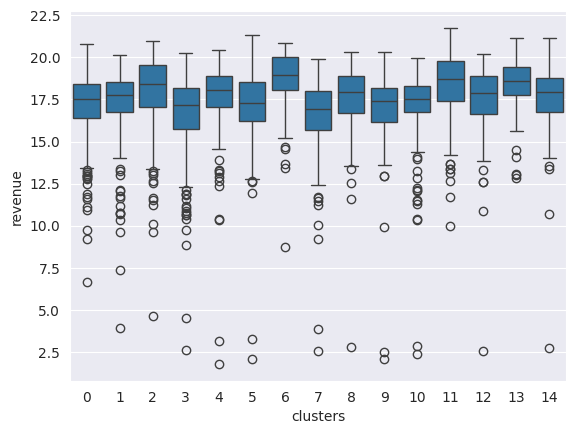

In [161]:
sns.set_style('darkgrid')
sns.boxplot(x='clusters',y='revenue',data=master_df)

In [162]:
tmdb_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 0 to 4798
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   budget                  3270 non-null   float64
 1   genres                  3270 non-null   object 
 2   id                      3270 non-null   int64  
 3   keywords                3270 non-null   object 
 4   popularity              3270 non-null   float64
 5   release_date            3270 non-null   object 
 6   revenue                 3270 non-null   float64
 7   runtime                 3270 non-null   float64
 8   title                   3270 non-null   object 
 9   vote_average            3270 non-null   float64
 10  vote_count              3270 non-null   float64
 11  keyword_strength        3270 non-null   float64
 12  release_year            3270 non-null   float64
 13  genres_list             3270 non-null   object 
 14  genre_revenue_strength  3270 non-null   float

In [163]:
COLUMNS_TO_USE = [
    'title',
    'budget',
    'revenue',
    'genre_revenue_strength',
    'keyword_strength',
    'clusters',
    'genres_list',
    'keywords',
    'popularity',
    'release_date',
    'release_year', 'action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
    'drama', 'family', 'fantasy', 'foreign', 'history', 'horror', 'music',
    'mystery', 'romance', 'science_fiction', 'thriller', 'war', 'western'
]

# Adding .copy() creates a new object and prevents SettingWithCopyWarning
master_df = master_df[COLUMNS_TO_USE].copy()

In [164]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 0 to 4798
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3270 non-null   object 
 1   budget                  3270 non-null   float64
 2   revenue                 3270 non-null   float64
 3   genre_revenue_strength  3270 non-null   float64
 4   keyword_strength        3270 non-null   float64
 5   clusters                3270 non-null   int32  
 6   genres_list             3270 non-null   object 
 7   keywords                3270 non-null   object 
 8   popularity              3270 non-null   float64
 9   release_date            3270 non-null   object 
 10  release_year            3270 non-null   float64
 11  action                  3270 non-null   int64  
 12  adventure               3270 non-null   int64  
 13  animation               3270 non-null   int64  
 14  comedy                  3270 non-null   int64

In [165]:
master_df['crowd'] = master_df['revenue'] / 5.5 # 5.5 dolars

In [166]:
def transform_datetime(master_df:pd.DataFrame,time_col:str):
  master_df[time_col] = pd.to_datetime(master_df[time_col], errors='coerce')
  master_df['month'] = master_df[time_col].dt.month
  master_df['week_release'] = master_df[time_col].dt.isocalendar().week
  # Corrected: calculate day of week from the actual datetime column
  master_df['realease_day_of_week'] = master_df[time_col].dt.dayofweek

  return master_df

In [167]:
# Re-run crowd calculation without warnings
master_df['crowd'] = master_df['revenue'] / 5.5

# Apply the corrected datetime transformation function
master_df = transform_datetime(master_df, 'release_date')

print("Transformations complete. Updated columns:")
print(master_df.columns)
display(master_df[['release_date', 'month', 'week_release', 'realease_day_of_week']].head())

Transformations complete. Updated columns:
Index(['title', 'budget', 'revenue', 'genre_revenue_strength',
       'keyword_strength', 'clusters', 'genres_list', 'keywords', 'popularity',
       'release_date', 'release_year', 'action', 'adventure', 'animation',
       'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy',
       'foreign', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'thriller', 'war', 'western', 'crowd', 'month',
       'week_release', 'realease_day_of_week'],
      dtype='object')


,release_date,month,week_release,realease_day_of_week
0,2009-12-10,12,50,3
1,2007-05-19,5,20,5
2,2015-10-26,10,44,0
3,2012-07-16,7,29,0
4,2012-03-07,3,10,2


Standard Box Office Decay Model

Most movies follow exponential decay:

Wt=W1×e−λt
W
t
	​

=W
1
	​

×e
−λt

Where:

W1
W
1
	​

 = opening week crowd

t
t = week number

λ
λ = decay rate

In [168]:
master_df.head(1)

,title,budget,revenue,genre_revenue_strength,keyword_strength,clusters,genres_list,keywords,popularity,release_date,...,mystery,romance,science_fiction,thriller,war,western,crowd,month,week_release,realease_day_of_week
0,Avatar,19.283571,21.748578,1.739210e+08,20.180652,11,"[action, adventure, fantasy, science_fiction]","[culture clash, future, space war, space colon...",150.437577,2009-12-10,...,0,0,1,0,0,0,3.954287,12,50,3


In [169]:
master_df['crowd_real'] = np.expm1(master_df['crowd']) # convert from log1p

In [170]:
cluster_total_crowd = master_df.groupby('clusters')['crowd_real'].mean()
cluster_total_crowd

,crowd_real
clusters,
0,22.981141
1,23.474466
2,27.107408
3,21.152128
4,25.090050
5,22.718147
6,30.527538
7,20.552371
8,24.895976


In [189]:
master_df.head(1)

,title,budget,revenue,genre_revenue_strength,keyword_strength,clusters,genres_list,keywords,popularity,release_date,...,science_fiction,thriller,war,western,crowd,month,week_release,realease_day_of_week,crowd_real,weekly_sim
0,Avatar,19.283571,21.748578,1.739210e+08,20.180652,11,"[action, adventure, fantasy, science_fiction]","[culture clash, future, space war, space colon...",150.437577,2009-12-10,...,1,0,0,0,3.954287,12,50,3,51.158485,"[20.722533804131466, 13.213270926448063, 8.425..."


In [172]:
COLUMNS_TO_TRAIN = [
  'budget',
  'clusters',
  'release_year',
  'crowd',
  'action',
  'realease_day_of_week',
  'week_release',
  'month',
  'crime',
  'animation',
  'adventure',
  'comedy',
  'documentary',
  'drama',
  'family',
  'fantasy',
  'foreign',
  'history',
  'horror',
  'music',
  'mystery',
  'romance',
  'science_fiction',
  'thriller',
  'war',
  'western'
]


In [173]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Split by year
train_df = master_df[master_df['release_year'] <= 2013]
test_df = master_df[master_df['release_year'] > 2013]

# Fix: Explicitly use COLUMNS_TO_TRAIN and ensure 'crowd' is target
# We must remove 'crowd' from the input features X
features = [col for col in COLUMNS_TO_TRAIN if col != 'crowd']

x_train = train_df[features]
y_train = train_df['crowd']

x_test = test_df[features]
y_test = test_df['crowd']

print(f"Training features: {x_train.columns.tolist()}")
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Training features: ['budget', 'clusters', 'release_year', 'action', 'realease_day_of_week', 'week_release', 'month', 'crime', 'animation', 'adventure', 'comedy', 'documentary', 'drama', 'family', 'fantasy', 'foreign', 'history', 'horror', 'music', 'mystery', 'romance', 'science_fiction', 'thriller', 'war', 'western']
Train shape: (2934, 25), Test shape: (336, 25)


In [174]:
# optuna session for chosing the best model

def objective_random(trial):

    model = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        max_depth=trial.suggest_int("max_depth", 3, 25),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        max_features=trial.suggest_float("max_features", 0.3, 1.0),
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    model.fit(x_train, y_train)

    preds = model.predict(x_test)

    mae = mean_absolute_error(y_test, preds)

    return mae


In [175]:
study_random = optuna.create_study(direction='minimize')
study_random.optimize(objective_random, n_trials=30)

[I 2026-02-18 13:03:14,916] A new study created in memory with name: no-name-d15e013e-eb22-4990-8f2a-d055a07c72e7
[I 2026-02-18 13:03:19,011] Trial 0 finished with value: 0.1840931628675151 and parameters: {'n_estimators': 274, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 0.5000704134589896}. Best is trial 0 with value: 0.1840931628675151.
[I 2026-02-18 13:03:32,665] Trial 1 finished with value: 0.18546355097316905 and parameters: {'n_estimators': 652, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.9432393312457266}. Best is trial 0 with value: 0.1840931628675151.
[I 2026-02-18 13:03:37,540] Trial 2 finished with value: 0.18417646162406762 and parameters: {'n_estimators': 471, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.41868566905239396}. Best is trial 0 with value: 0.1840931628675151.
[I 2026-02-18 13:03:47,230] Trial 3 finished with value: 0.18556473176801822 and parameters

In [176]:
print(study_random.best_params)

{'n_estimators': 557, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.41209040337997893}


In [183]:
# Initialize the model with the best parameters found by Optuna
best_model_forest = RandomForestRegressor(**study_random.best_params, random_state=42)

# Fit the optimized model to the training data
best_model_forest.fit(x_train,y_train)

# Generate new predictions
pred_log = best_model_forest.predict(x_test)
pred_total = np.expm1(pred_log)


In [193]:
import joblib

joblib.dump(best_model_forest,'best_model_attendance.pkl')

['best_model_attendance.pkl']

In [184]:
print(f'MAE : {mean_absolute_error(y_test,pred_log)}')
print(f'MSE : {mean_squared_error(y_test,pred_log)}')
print(f'R2 : {r2_score(y_test,pred_log)}')

MAE : 0.18304143642135998
MSE : 0.06282557186584793
R2 : 0.4770202129570691




MAE : 0.18304143642135998
MSE : 0.06282557186584793
R2 : 0.4770202129570691
--- Good metrics for attendance prediction --- (log_scale)

In [196]:
def simulate_week_crowd(total_crowd, decay=0.45, weeks=5):
    """
    Takes a total crowd figure and distributes it over X weeks
    using an exponential decay model.
    """
    # weight decay for the weeks
    weights = np.array([
        np.exp(-decay * i)
        for i in range(weeks)
    ])

    # Normalize weights so they sum to 1
    weights = weights / weights.sum()

    # Calculate weekly crowd
    weekly = total_crowd * weights

    return weekly.tolist()



In [180]:
master_df['weekly_sim'] = master_df['crowd_real'].apply(
    lambda x : simulate_week_crowd(x)
)

master_df[['title','weekly_sim','crowd_real']]

weekly_df = master_df.explode('weekly_sim').copy()


In [195]:
master_df.head(1)

,title,budget,revenue,genre_revenue_strength,keyword_strength,clusters,genres_list,keywords,popularity,release_date,...,science_fiction,thriller,war,western,crowd,month,week_release,realease_day_of_week,crowd_real,weekly_sim
0,Avatar,19.283571,21.748578,1.739210e+08,20.180652,11,"[action, adventure, fantasy, science_fiction]","[culture clash, future, space war, space colon...",150.437577,2009-12-10,...,1,0,0,0,3.954287,12,50,3,51.158485,"[20.722533804131466, 13.213270926448063, 8.425..."


In [198]:
# Simulate Movie_A
movie_a = {
    "title": "Movie_A",
    "budget": 50.0,
    "revenue": 0,
    "genre_revenue_strength": 1.2,
    "keyword_strength": 2.0,
    "clusters": 6,
    "genres_list": ["action", "adventure"],
    "keywords": ["hero", "quest"],
    "popularity": 75.0,
    "release_date": pd.to_datetime("2026-03-01"),
    "release_year": 2026,
    "action": 1,
    "adventure": 1,
    "animation": 0,
    "comedy": 0,
    "crime": 0,
    "documentary": 0,
    "drama": 0,
    "family": 0,
    "fantasy": 0,
    "foreign": 0,
    "history": 0,
    "horror": 0,
    "music": 0,
    "mystery": 0,
    "romance": 0,
    "science_fiction": 0,
    "thriller": 0,
    "war": 0,
    "western": 0,
    "month": 3,
    "week_release": 9,
    "realease_day_of_week": 1
}


In [192]:
# SIMULATING MOVIE THEATERS BY REGION

def movieTheaters(NUM_CINEMAS) -> pd.DataFrame:
    SEATS_STRUCTURE = [225,225,160,160,80,80,80,80]
    cinemas = []

    for i in range(NUM_CINEMAS):
      if i < 21:
        region == 'North'
      elif i < 42:
        region == 'South'
      elif i < 63:
        region == 'East'
      else:
        region == 'West'

      cinema_name = f'Cinema_{i+1}'

      for r,cap in enumerate(SEATS_STRUCTURE,start=1):
        cinemas.append({
            'cinema_id' : i+1,
            'region' : region,
            'capacity':cap
        })

    cinemas_df = pd.DataFrame(cinemas)
    return cinemas_df

In [ ]:
#ALLOCATE MOVIE WEEKLY

1️⃣ About “Retraining with New Movies”

You said:

we receive new movies and don’t have data

Correct — and this is important:

For new movies, you do not retrain the whole model every time.

Instead:

✅ Correct Flow

Train clustering + prediction model on historical movies.

Save:

MultiLabelBinarizer

PCA

KMeans

Regression model

For a new movie:

Encode genres/keywords

Transform with saved PCA

Predict cluster using trained KMeans

Predict total crowd using trained ML model

No retraining needed unless you update dataset periodically.

2️⃣ About Splitting DataFrames by Cluster

You said:

split movies by cluster and do time series per cluster

That’s actually a very good idea — but keep it simple.

Instead of full time series modeling per cluster (which may be unstable due to small sample size), do:

Per Cluster:

Compute average total crowd

Estimate decay rate λ

Estimate opening share %

Store something like:

cluster	avg_opening_share	avg_decay
0	0.42	0.38
1	0.35	0.55
2	0.50	0.32

That becomes your behavioral template.

Then when new movie → cluster 3 → use cluster 3 decay behavior.

Simple. Clean. Defensible.

3️⃣ Cinema Simulation (85 Theaters)

Now this part is very good.

You defined:

85 cinemas

Max capacity: 255

Avg: 160

Small: 80

Regions:

40% South

35% North

12.5% East

12.5% West

That’s realistic structure.

4️⃣ How You Should Allocate

Simple rule-based system (good choice):

For each week:

Sort movies by predicted weekly crowd (descending)

Assign biggest movies to biggest rooms

Compute:

occupancy=predicted_crowdcapacity×showtimes
occupancy=
capacity×showtimes
predicted_crowd
	​


Assume:

4 showtimes per day

7 days per week

Weekly room capacity:

room_capacity×28
room_capacity×28

If occupancy > 100%, cap it at 100%.

5️⃣ Final Output Excel Structure

You said you need:

Movie name

Cinema

Room

Week

Capacity

Predicted crowd

Occupancy %

Perfect.

Your final dataframe should look like:

| Movie | Region | Cinema_ID | Room_ID | Week | Room_Capacity | Weekly_Capacity | Predicted_Crowd | Occupancy_% |